In [2]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [5]:
!pip install evaluate
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [203]:
import json
from transformers import PreTrainedTokenizerFast, CamembertForTokenClassification, AutoModelForTokenClassification,TrainingArguments,DataCollatorForTokenClassification,Trainer
import yaml
import re
from datasets import load_dataset,Dataset, load_metric
import evaluate
import datasets
from sklearn.model_selection import train_test_split
import importlib
import ast
import pandas as pd
import preprocess
import torch
import accelerate
import matplotlib.pyplot as plt


In [51]:
importlib.reload(preprocess)

<module 'preprocess' from '/content/preprocess.py'>

In [52]:
literal2tag=preprocess.literal2tag

In [53]:
df=preprocess.get_dataset()

sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence not in right format :  
sentence n

In [54]:
df=pd.read_csv('data.csv')

In [55]:
dataset=load_dataset('csv',data_files='data.csv',num_proc=10)

Setting num_proc from 10 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split: 0 examples [00:00, ? examples/s]

In [56]:
features=datasets.Features(
                {
                    "text": datasets.Sequence(datasets.Value("string")),
                    "labels": datasets.Sequence(
                        datasets.features.ClassLabel(
                            num_classes=len(literal2tag),
                            names=literal2tag,
                        )
                    ),

                }
            )

In [57]:
features

{'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'labels': Sequence(feature=ClassLabel(names=['age', 'birth_date', 'civil_status', 'education_level', 'employer', 'firstname', 'link', 'lob', 'maiden_name', 'nationality', 'observation', 'occupation', 'surname', 'surname_household'], id=None), length=-1, id=None)}

In [58]:
dataset = dataset['train'].map(lambda example: {"text": ast.literal_eval(example["text"]), "labels": ast.literal_eval(example["labels"])}, features=features)

Map:   0%|          | 0/23054 [00:00<?, ? examples/s]

In [59]:
dataset=dataset.train_test_split(test_size=0.2,seed=3)

In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 18443
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4611
    })
})

In [61]:
tokenizer=PreTrainedTokenizerFast.from_pretrained('camembert-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CamembertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [62]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [63]:
len(tokenizer)

32005

In [64]:
label_all_tokens = False
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["text"], padding=True, is_split_into_words=True,return_tensors='pt')
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [65]:
tokenized_datasets=dataset.map(tokenize_and_align_labels, batched=True,num_proc=10)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=10):   0%|          | 0/18443 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/4611 [00:00<?, ? examples/s]

In [66]:
model=AutoModelForTokenClassification.from_pretrained('camembert-base', num_labels=14)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
model.resize_token_embeddings(len(tokenizer)+1)

Embedding(32006, 768)

In [68]:
model

CamembertForTokenClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32006, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [69]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18443
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4611
    })
})

In [70]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['test']['input_ids'][3])

['<s>',
 '▁Mah',
 'é',
 '▁Pierre',
 '▁Taille',
 'ur',
 '▁32',
 '</s>',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [24]:
#model(input_ids=tokenized_datasets['train']['input_ids'][0:1],attention_mask=tokenized_datasets['train']['attention_mask'][0:1],token_type_ids=tokenized_datasets['train']['token_type_ids'][0:1])

In [71]:
args = TrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    output_dir='/home/onyxia/work'
)

In [72]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [73]:
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='camembert-base', vocab_size=32005, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	6: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word

In [168]:
!pip install seqeval
metric = load_metric("seqeval",zero_division=0)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [175]:
import numpy as np
import torch.nn.functional as F

label_list=literal2tag
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=-1)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

"recall": metric2.compute(predictions=Value(true_predictions), references=Value(true_labels),average='micro'),
        "f1": metric3.compute(predictions=Value(true_predictions), references=Value(true_labels),average='micro'),
        "accuracy": metric4.compute(predictions=Value(true_predictions), references=Value(true_labels)),

In [76]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [77]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.173300,0.121349,0.973268,0.972346,0.972807,0.973493
2,0.084800,0.082503,0.974234,0.973970,0.974102,0.974350
3,0.070100,0.076479,0.973694,0.973474,0.973584,0.973854


<ipython-input-75-d4a143bd0101>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=2)
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: surname_household seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: firstname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: occupation seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: link seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/l

TrainOutput(global_step=6918, training_loss=0.19792288195435523, metrics={'train_runtime': 524.1125, 'train_samples_per_second': 105.567, 'train_steps_per_second': 13.199, 'total_flos': 804059068508004.0, 'train_loss': 0.19792288195435523, 'epoch': 3.0})

In [78]:
trainer.evaluate()

<ipython-input-75-d4a143bd0101>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=2)


{'eval_loss': 0.07647912949323654,
 'eval_precision': 0.9736937099539753,
 'eval_recall': 0.9734740830964947,
 'eval_f1': 0.9735838841390512,
 'eval_accuracy': 0.9738538520488662,
 'eval_runtime': 10.2796,
 'eval_samples_per_second': 448.56,
 'eval_steps_per_second': 56.131,
 'epoch': 3.0}

In [ ]:
final_predictions=trainer.predict(tokenized_datasets['test'])

In [156]:
label_list

['age',
 'birth_date',
 'civil_status',
 'education_level',
 'employer',
 'firstname',
 'link',
 'lob',
 'maiden_name',
 'nationality',
 'observation',
 'occupation',
 'surname',
 'surname_household']

In [197]:
def examine_erros(res):
  preds=res.predictions
  true=res.label_ids.tolist()
  preds=np.argmax(F.softmax(torch.Tensor(preds),dim=-1),axis=-1).tolist()
  sentence_level_errors=0
  for i in range (len(preds)):
    prediction=preds[i]
    label=true[i]
    true_prediction=[label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    true_label =[label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    result = metric.compute(predictions=[true_prediction], references=[true_label])
    if result['overall_accuracy']!=1:
      sentence_level_errors=+1
      print(true_prediction,true_label)
  return sentence_level_errors

In [198]:
examine_erros(final_predictions)

['surname_household', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality'] ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality']
['surname_household', 'firstname', 'occupation', 'civil_status'] ['surname', 'firstname', 'occupation', 'civil_status']
['surname', 'firstname', 'occupation', 'link', 'employer', 'age'] ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date']
['surname_household', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality'] ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'nationality']
['surname', 'firstname', 'occupation', 'age'] ['surname', 'firstname', 'link', 'age']
['surname', 'firstname', 'occupation', 'link', 'age'] ['surname_household', 'firstname', 'occupation', 'link', 'age']
['surname', 'firstname', 'occupation', 'birth_date'] ['surname', 'firstname', 'link', 'birth_date']
['surname', 'firstname', 'link', 'age'] ['surname', 'firstname', 

ZeroDivisionError: division by zero

In [187]:
import numpy as np
import torch.nn.functional as F

label_list=literal2tag
def save_preds(p):
    predictions, labels = p
    predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=-1)

    # Remove ignored index (special tokens)
    true_predictions = [
        str([label_list[p] for (p, l) in zip(prediction, label) if l != -100])
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        str([label_list[l] for (p, l) in zip(prediction, label) if l != -100])
        for prediction, label in zip(predictions, labels)
    ]

    results=pd.DataFrame({'predictions':true_predictions,'labels':true_labels}).to_csv('/content/results.csv',index=False)
    return results

In [188]:
save_preds((final_predictions.predictions,final_predictions.label_ids))

<ipython-input-187-7e11c98d8d77>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=-1)


In [189]:
results=pd.read_csv('results.csv')

In [190]:
results

,predictions,labels
0,"['surname_household', 'firstname', 'occupation...","['surname_household', 'firstname', 'occupation..."
1,"['surname', 'firstname', 'occupation', 'link',...","['surname', 'firstname', 'occupation', 'link',..."
2,"['surname', 'firstname', 'link', 'age']","['surname', 'firstname', 'link', 'age']"
3,"['surname_household', 'firstname', 'occupation...","['surname_household', 'firstname', 'occupation..."
4,"['surname', 'firstname', 'link', 'age', 'civil...","['surname', 'firstname', 'link', 'age', 'civil..."
...,...,...
4606,"['surname', 'firstname', 'occupation', 'link',...","['surname', 'firstname', 'occupation', 'link',..."
4607,"['surname_household', 'firstname', 'occupation...","['surname_household', 'firstname', 'occupation..."
4608,"['surname', 'firstname', 'link', 'age']","['surname', 'firstname', 'link', 'age']"
4609,"['surname_household', 'firstname', 'occupation...","['surname_household', 'firstname', 'occupation..."


In [200]:
error_rates=dict()
for i in range(len(results)):
  preds=ast.literal_eval(results.loc[i]['predictions'])
  labels=ast.literal_eval(results.loc[i]['labels'])
  for j in range(len(preds)):
    if labels[j]!=preds[j]:
      if labels[j] not in error_rates.keys():
        error_rates[labels[j]]=1
      else:
        error_rates[labels[j]]=error_rates[labels[j]]+1

In [201]:
error_rates

{'surname': 356,
 'birth_date': 7,
 'link': 61,
 'surname_household': 59,
 'occupation': 57,
 'nationality': 23,
 'employer': 9,
 'age': 3,
 'firstname': 5}

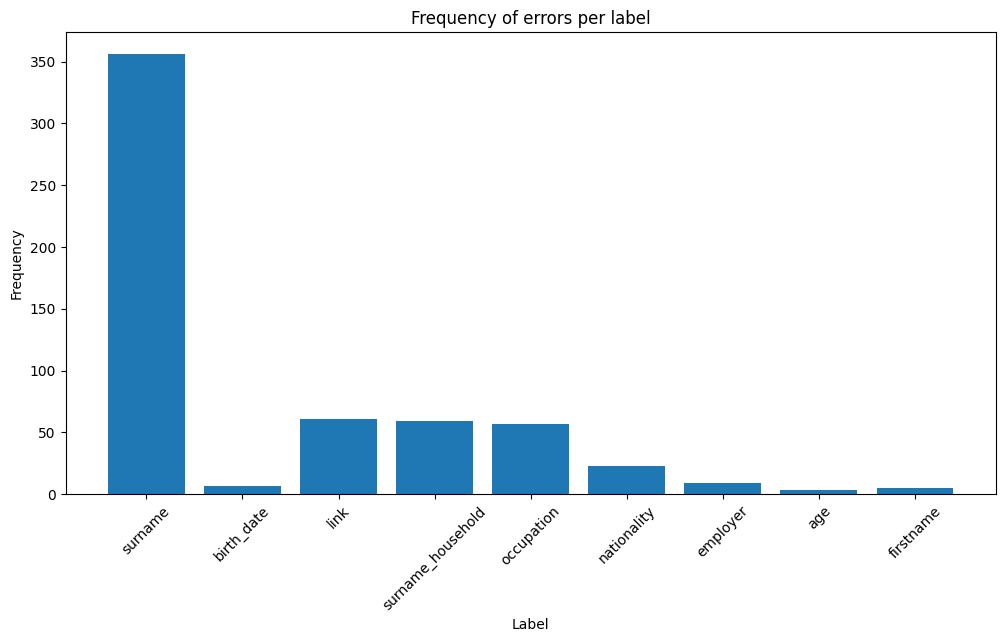

In [216]:
labels = list(error_rates.keys())
counts = list(error_rates.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of errors per label')

# Rotate x labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

## **A few tests**

In [33]:
tokenized_datasets['train']['input_ids'][0]

[5,
 84,
 5008,
 7593,
 470,
 27312,
 918,
 8,
 401,
 3294,
 6,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005,
 32005]

In [34]:
predictions=trainer.predict(tokenized_datasets['test'])

<ipython-input-29-d4a143bd0101>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = np.argmax(F.softmax(torch.Tensor(predictions)), axis=2)


In [35]:
import torch
import torch.nn.functional as F
F.softmax(torch.Tensor(predictions.predictions[3]),dim=-1).argmax(dim=-1)

tensor([ 2, 13, 13,  5, 11, 11,  0,  2,  2,  2,  2,  2,  2,  2, 11,  6,  2,  2,
         2,  2,  2,  0,  0,  0,  0])

In [36]:
dataset['test']['labels'][:10]

[[13, 5, 11, 6, 0],
 [12, 5, 11, 6, 1, 9],
 [12, 5, 6, 0],
 [13, 5, 11, 0],
 [12, 5, 6, 0, 2],
 [13, 5, 11, 6, 1, 9],
 [12, 5, 11, 6, 1, 9],
 [12, 5, 11, 6, 1, 9],
 [12, 5, 11, 6, 4, 0],
 [12, 5, 11, 1, 2, 7]]

In [37]:
tokenized_datasets['test']['labels'][3]

[-100,
 13,
 -100,
 5,
 11,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100]

In [38]:
tokenizer.pad_token_id

32005

In [7]:
import evaluate
!pip install seqeval
seqeval = evaluate.load('seqeval')
predictions = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
references = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
results = seqeval.compute(predictions=predictions, references=references)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=18e0d9b46838bc9b95d6c03afe87d41afec5ac69ea2ab11da619bc454bf346a1
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [8]:
results

{'MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 0.5,
 'overall_recall': 0.5,
 'overall_f1': 0.5,
 'overall_accuracy': 0.8}

In [33]:
predictions = [['age','surname','link'], ['age','age','link']]
references = [['birth_date','link','surname'], ['age','age','link']]

In [34]:
results = seqeval.compute(predictions=predictions, references=references)

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: birth_date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: link seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: surname seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: age seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [35]:
results

{'ge': {'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'number': 1},
 'ink': {'precision': 0.5, 'recall': 0.5, 'f1': 0.5, 'number': 2},
 'irth_date': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'urname': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.4,
 'overall_recall': 0.4,
 'overall_f1': 0.4000000000000001,
 'overall_accuracy': 0.5}

In [44]:
from sklearn.metrics import precision_score, f1_score

def calculate_precision(predictions, true_values):
    # Flatten the predictions and true values
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_true_values = [item for sublist in true_values for item in sublist]
    # Calculate precision
    precision = precision_score(flat_true_values, flat_predictions, average='weighted')
    return precision

def calculate_f1_score(predictions, true_values):
    # Flatten the predictions and true values
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_true_values = [item for sublist in true_values for item in sublist]
    # Calculate F1 score
    f1 = f1_score(flat_true_values, flat_predictions, average='weighted')
    return f1

In [45]:
calculate_precision(predictions,references)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.38888888888888884

In [46]:
calculate_f1_score(predictions,references)

0.43333333333333335

In [29]:
def calculate_accuracy(predictions,true_values):
    acc=0
    length=0
    for i in range (len(predictions)):
        length=length+len(predictions[i])
        for j in range (len(predictions[i])):
            if (predictions[i][j]==true_values[i][j]):
                acc=acc+1
    return acc/length

In [47]:
calculate_accuracy(predictions,references)

0.5